<a href="https://colab.research.google.com/github/Alexis-CAPON/cse437-reinforcement-learning/blob/main/lab11_MBRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 11: Solving the mountaincar problem in 1 episode

In this lab, you will use a Gaussian Process (GP) model to learn the dynamics of the Mountain Car system.
Then, based on Lab 8, you will use MPPI or MPPI-Simplified to write the MPC loop that controls the vehicle.
The goal is to solve the Mountain Car problem in one episode.

## Provided code
* The following code implements a Gaussian Process regression model that predicts the next-state change (Δx) given [position, velocity, action].
* Example training data collected from random actions.



In [8]:
# %matplotlib widget
%matplotlib inline

In [9]:
!pip install gpytorch

# Gaussian Process

In [10]:
import torch
import gpytorch
import numpy as np

# ============================================================
# ---- Base Exact GP model -------------------
# ============================================================

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Choose kernel type
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RationalQuadraticKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ============================================================
# ---- Individual GP Manager: handles data + normalization ----
# ============================================================

class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=1000):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.trained = False
        self.X_train = []
        self.Y_train = []

        self.likelihood = None
        self.model = None


    # ----------------------------- #
    #        FIT / INITIAL TRAIN    #
    # ----------------------------- #
    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        self.X_train = X.clone()
        self.Y_train = Y.clone()

        self.retrain()

    def retrain(self):
        # Normalize the input/output and then train the model
        self._compute_normalization()
        self._train_model()

    # ----------------------------- #
    #       ADD NEW DATA POINTS     #
    # ----------------------------- #
    def add_data(self, X_new, Y_new, retrain=True):
        """
        Add new data (single or batch) to GP training set.
        Optionally retrain the model.
        """
        X_new = torch.tensor(X_new, dtype=torch.float32)
        Y_new = torch.tensor(Y_new, dtype=torch.float32).flatten()  # ensure 1D

        # Also flatten stored Y to ensure shape consistency
        if self.Y_train.ndim > 1:
            self.Y_train = self.Y_train.flatten()

        # Append new data
        self.X_train = torch.cat([self.X_train, X_new], dim=0)
        self.Y_train = torch.cat([self.Y_train, Y_new], dim=0)

        if retrain:
            self.retrain()

    # ----------------------------- #
    #         INTERNAL UTILS        #
    # ----------------------------- #
    def _compute_normalization(self):
        self.X_mean, self.X_std = self.X_train.mean(0), self.X_train.std(0)
        self.Y_mean, self.Y_std = float(self.Y_train.mean(0)), float(self.Y_train.std(0))

        Xn = (self.X_train - self.X_mean) / self.X_std
        Yn = (self.Y_train - self.Y_mean) / self.Y_std

        self.Xn, self.Yn = Xn, Yn

    def dataset(self):
        # Extract training data (already stored inside the wrapper)
        X_train = self.X_train.numpy()
        Y_train = self.Y_train.numpy()
        return X_train, Y_train


    def _train_model(self):
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.likelihood.noise_covar.initialize(noise=1e-3)
        self.model = ExactGPModel(self.Xn, self.Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=self.X_train.shape[-1])

        # -------------------------------------------------
        # Train the model
        # -------------------------------------------------
        self.train_gp(self.model, self.likelihood, self.Xn, self.Yn)
        self.trained = True

    def train_gp(self, model, likelihood, x, y):
        model.train(); likelihood.train()
        opt = torch.optim.Adam(model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        for _ in range(self.iters):
            opt.zero_grad()
            out = model(x)
            loss = -mll(out, y)
            loss.backward()
            opt.step()
        model.eval(); likelihood.eval()

    def predict(self, X):
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        # Normalize the input
        X = torch.as_tensor(X, dtype=torch.float32)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(Xn))

            # Unonormalize the output
            mean = pred.mean.cpu().numpy() * self.Y_std + self.Y_mean
            var = pred.variance.cpu().numpy() * (self.Y_std ** 2)
        # Return the unnormalized output
        return mean, var


# Setup environment and collect initial data

In [11]:
import gymnasium as gym
# import gym
import numpy as np
import torch
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# 1.  Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)
n_state = env.observation_space.shape[0]    # [position, velocity]
n_action = env.action_space.shape[0]        # 1 continuous action
n_output = 2                                # Δpos, Δvel


# --------------------------------------------------------------
# 2.  Collect initial random data
# --------------------------------------------------------------
data = {'X': [], 'Y': []}

obs, _ = env.reset(seed=0)
for _ in range(200):  # collect 500 transitions
    a = env.action_space.sample()  # random continuous action in [-1,1]
    x_next, r, term, trunc, _ = env.step(a)
    data['X'].append(np.concatenate([obs, a]))   # [pos, vel, action]
    data['Y'].append(x_next - obs)               # Δstate
    obs = x_next
    if term or trunc:
        obs, _ = env.reset()

X = np.array(data['X'])[::3]
Y = np.array(data['Y'])[::3]
print(f"Collected {len(X)} transitions.")


# --------------------------------------------------------------
# 3.  Train GP dynamics models
# --------------------------------------------------------------
gps = [GPManager(kernel='RBF', iters=300) for _ in range(n_output)]

for d in range(n_output):
    gps[d].fit(X, Y[:, d])
    print(f"Trained GP for Δstate[{d}] with {len(X)} samples.")


Collected 67 transitions.
Trained GP for Δstate[0] with 67 samples.
Trained GP for Δstate[1] with 67 samples.


# Visualize collected data

Plotting for action a=-1.0
Values near action a=-1.0 n=21


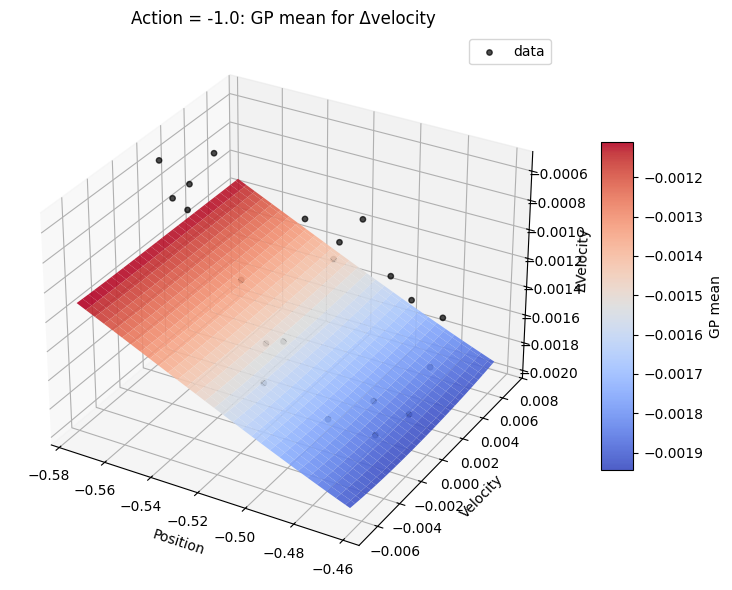

Plotting for action a=0.0
Values near action a=0.0 n=31


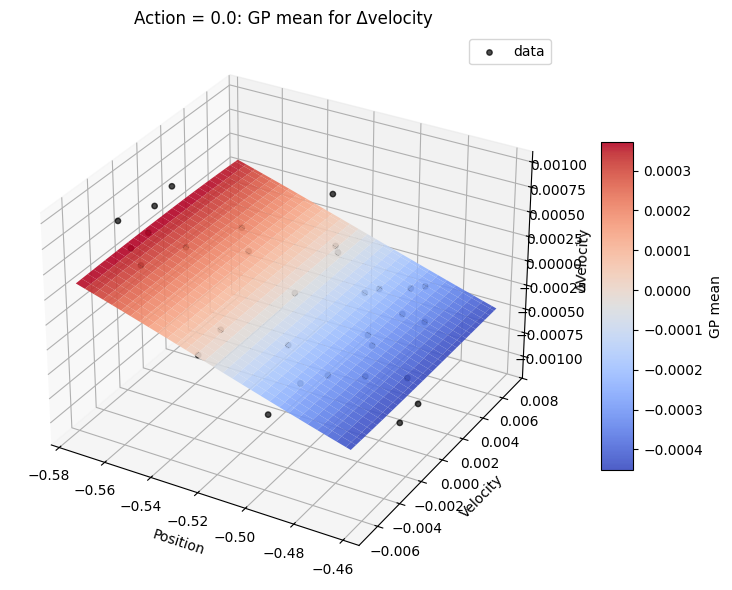

Plotting for action a=1.0
Values near action a=1.0 n=15


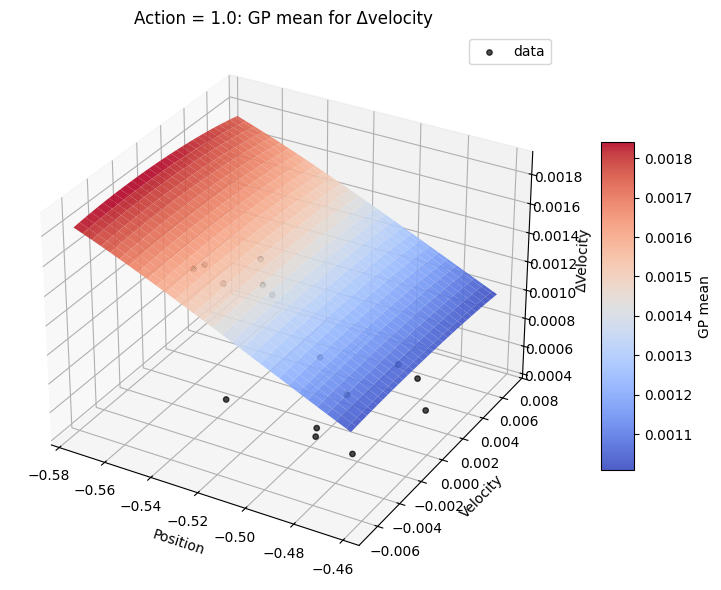

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --------------------------------------------------------
# Visualization setup
# --------------------------------------------------------
gp = gps[1]   # GP for Δvelocity
a_values = [-1.0, 0.0, 1.0]  # representative actions

# Get raw training data
X_train, Y_train = gp.dataset()
pos, vel, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
dvel = Y_train  # Δvelocity targets

# --------------------------------------------------------
# Define grid for visualization
# --------------------------------------------------------
p_min, p_max = pos.min(), pos.max()
v_min, v_max = vel.min(), vel.max()

p_grid = np.linspace(p_min, p_max, 60)
v_grid = np.linspace(v_min, v_max, 60)
P, V = np.meshgrid(p_grid, v_grid)

# --------------------------------------------------------
# Generate and plot for each action
# --------------------------------------------------------
for a_fixed in a_values:
    print(f"Plotting for action a={a_fixed}")

    # Predict using the GP for this action
    X_grid = np.column_stack([P.ravel(), V.ravel(), np.full_like(P.ravel(), a_fixed)])
    Mean, var = gp.predict(X_grid)
    Mean = Mean.reshape(P.shape)

    # --------------------------------------------------------
    # Plot as surface
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(P, V, Mean, cmap='coolwarm',
                           linewidth=0, antialiased=True, alpha=0.9)

    # Overlay training data close to this action value
    mask = np.abs(act - a_fixed) < 0.5
    print(f"Values near action a={a_fixed} n={np.sum(mask)}")
    ax.scatter(pos[mask], vel[mask], dvel[mask],
               color='k', s=15, alpha=0.7, label='data')

    # --------------------------------------------------------
    # Labels and title
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('ΔVelocity')
    ax.set_title(f"Action = {a_fixed:.1f}: GP mean for Δvelocity")

    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label='GP mean')
    ax.legend()
    plt.tight_layout()
    plt.show()


Values near action a=-1.0 → n=21


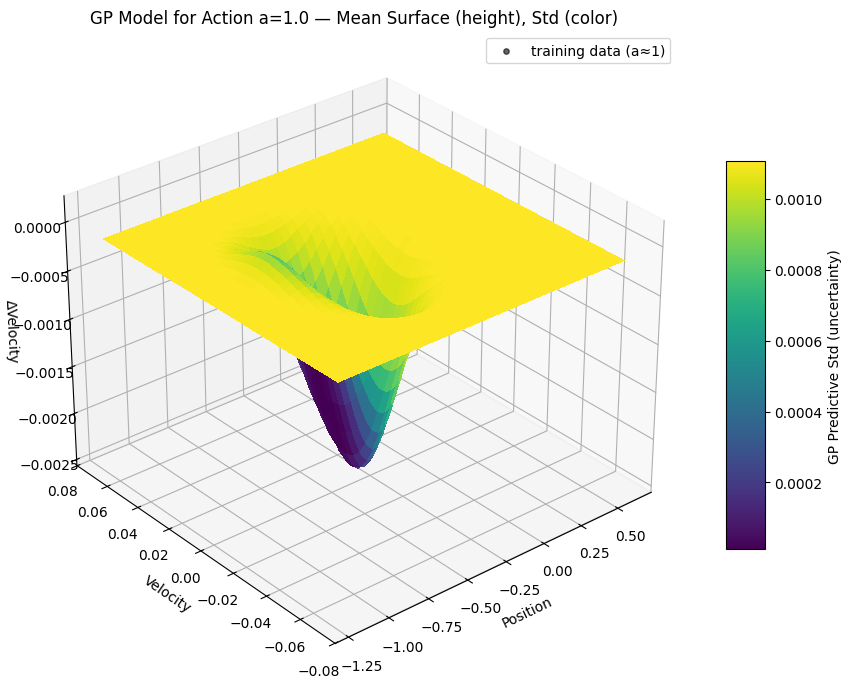

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------------------------------------------------------
# Choose which GP to visualize
# --------------------------------------------------------
gp = gps[1]   # GP for Δvelocity (index 0 for Δposition)
a_fixed = -1.0 # fixed continuous action (maximum thrust)

# --------------------------------------------------------
# Get training data
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
pos, vel, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
dvel = Y_train

# Select samples close to a=1 for overlay
mask = np.abs(act - a_fixed) < 0.5
print(f"Values near action a={a_fixed} → n={np.sum(mask)}")

# --------------------------------------------------------
# Define position–velocity grid
# --------------------------------------------------------
p_min, p_max = -1.2, 0.6
v_min, v_max = -0.07, 0.07
p_grid = np.linspace(p_min, p_max, 80)
v_grid = np.linspace(v_min, v_max, 80)
P, V = np.meshgrid(p_grid, v_grid)

# Query points for the fixed action
X_grid = np.column_stack([P.ravel(), V.ravel(), np.full_like(P.ravel(), a_fixed)])

# --------------------------------------------------------
# GP predictions
# --------------------------------------------------------
Mean, Var = gp.predict(X_grid)
Mean = Mean.reshape(P.shape)
Std = np.sqrt(Var.reshape(P.shape))

# Normalize Std for color mapping
norm = plt.Normalize(vmin=Std.min(), vmax=Std.max())
colors = plt.cm.viridis(norm(Std))

# --------------------------------------------------------
# Plot surface: Mean as height, Std as color
# --------------------------------------------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    P, V, Mean,
    facecolors=colors, linewidth=0, antialiased=False, shade=False
)

# Colorbar = predictive uncertainty
m = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
m.set_array(Std)
cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('GP Predictive Std (uncertainty)')

# Overlay raw data (samples with similar a)
ax.scatter(
    pos[mask], vel[mask], dvel[mask],
    color='k', s=15, alpha=0.6, label='training data (a≈1)'
)

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('ΔVelocity')
ax.set_title("GP Model for Action a=1.0 — Mean Surface (height), Std (color)")
ax.view_init(elev=30, azim=230)
ax.legend()
plt.tight_layout()
plt.show()


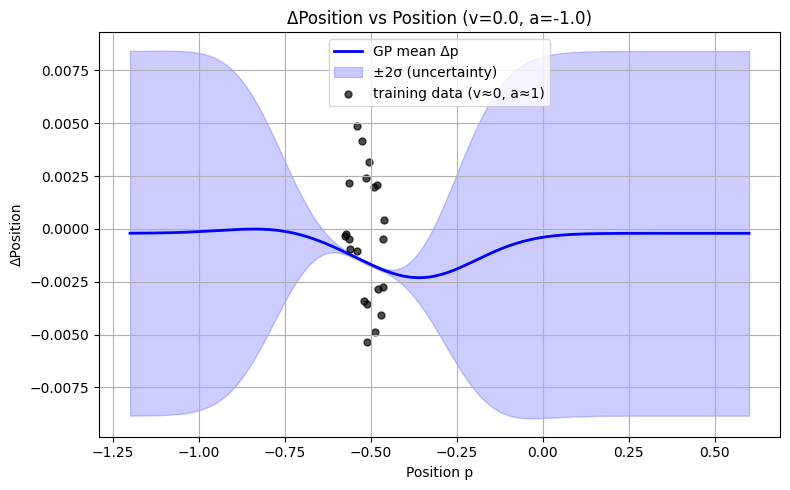

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# Choose GP: Δposition model
# --------------------------------------------------------
gp = gps[0]       # GP for Δposition
v_fixed = 0.0     # fix velocity
a_fixed = -1.0     # fix action

# --------------------------------------------------------
# Define position grid
# --------------------------------------------------------
p_min, p_max = -1.2, 0.6
p_grid = np.linspace(p_min, p_max, 200)

# Construct query points [p, v_fixed, a_fixed]
X_query = np.column_stack([p_grid, np.full_like(p_grid, v_fixed), np.full_like(p_grid, a_fixed)])

# --------------------------------------------------------
# Predict GP mean and std
# --------------------------------------------------------
Mean, Var = gp.predict(X_query)
Std = np.sqrt(Var)

# --------------------------------------------------------
# Plot mean ± std as shaded region
# --------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(p_grid, Mean, 'b-', lw=2, label='GP mean Δp')
plt.fill_between(p_grid, Mean - 2*Std, Mean + 2*Std,
                 color='blue', alpha=0.2, label='±2σ (uncertainty)')

# --------------------------------------------------------
# Overlay training data near v=0 and a=1
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
mask = (np.abs(X_train[:, 1] - v_fixed) < 0.01) & (np.abs(X_train[:, 2] - a_fixed) < 0.5)
plt.scatter(X_train[mask, 0], Y_train[mask], color='k', s=25, alpha=0.7, label='training data (v≈0, a≈1)')

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
plt.xlabel("Position p")
plt.ylabel("ΔPosition")
plt.title(f"ΔPosition vs Position (v={v_fixed}, a={a_fixed})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Exercise 1
Use the trained GP as a learned dynamics model to control the Mountain Car environment using Model Predictive Control (MPC).

You can choose between:
* MPPI (Model Predictive Path Integral) – probabilistic trajectory weighting, or
* MPPI-Simplified (Random Shooting) – select the lowest-cost trajectory among random samples.

Your controller should plan ahead, predict future states using the GP, and drive the car to reach the goal in a single episode.

### Expected Outcome
By the end of the exercise, your controller should:
* Use the GP model to predict the system dynamics
* Plan and select optimal actions using MPC
* Drive the car to reach the goal in one episode

### Deliverables

* Your implementation of the mpc_action() function
* A plot showing the car’s position versus time
* A short explanation (2–3 sentences) describing how MBRL is more efficient than Q-learning.
* Describe the downside of MBRL over Q-learning

Starting MPC simulation with H=20, K=1000
Step 50: Position = -0.3366, Velocity = -0.0080
Step 100: Position = -0.3389, Velocity = 0.0037
Step 150: Position = -0.4305, Velocity = -0.0000
Step 200: Position = -0.3233, Velocity = -0.0037
Step 250: Position = -0.4201, Velocity = 0.0041
Step 300: Position = -0.3992, Velocity = -0.0110
Step 350: Position = -0.2530, Velocity = 0.0079
Step 400: Position = -0.9976, Velocity = -0.0266
Step 450: Position = -0.2023, Velocity = 0.0053
Step 500: Position = -1.1668, Velocity = -0.0085
Episode ended at step 500. Goal reached: False
Simulation finished.


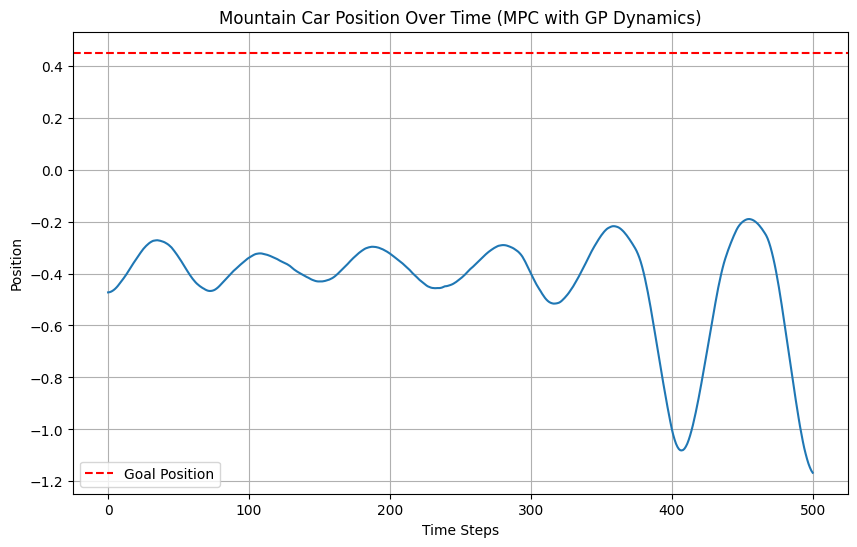

In [25]:
import numpy as np
import torch

# ============================================================
# ---- Cost function -----------------------------------------
# ============================================================
def cost_fn(state, action):
    # state: (K, n_state) -> (K, 2) for position, velocity
    # action: (K, n_action) -> (K, 1) or (K,) for single action

    position = state[:, 0]
    velocity = state[:, 1]

    # Ensure action is 1D for broadcasting if it's (K,1)
    if action.ndim > 1 and action.shape[1] == 1:
        action = action.squeeze(1)

    # Goal reward: Large negative cost if not at goal
    # Goal position is >= 0.45
    goal_cost = np.where(position < 0.45, 1000.0 * (0.45 - position), 0.0)

    # Action cost: Penalize large actions to encourage energy efficiency
    action_cost = 0.1 * (action**2)

    # Velocity cost: Penalize negative velocity when below goal position
    velocity_cost = np.where((position < 0.45) & (velocity < 0), 50.0 * np.abs(velocity), 0.0)

    return goal_cost + action_cost + velocity_cost


# ============================================================
# ---- Dynamics Model using GP -------------------------------
# ============================================================
# This function remains largely the same for a single prediction,
# but we'll use it in a batched way within mpc_action.
def gp_dynamics(state_batch, action_batch, gps):
    # state_batch: (K, n_state)
    # action_batch: (K, n_action)

    # Ensure action_batch is 2D, even if n_action is 1
    if action_batch.ndim == 1:
        action_batch = action_batch.reshape(-1, 1)

    input_data = np.concatenate([state_batch, action_batch], axis=1)

    # Predict delta_state for position and velocity using respective GPs
    # gps[0] is for Δposition, gps[1] is for Δvelocity
    delta_pos_mean, _ = gps[0].predict(input_data)
    delta_vel_mean, _ = gps[1].predict(input_data)

    # Ensure predictions are 1D arrays of shape (K,)
    delta_pos = delta_pos_mean.flatten()
    delta_vel = delta_vel_mean.flatten()

    # Update state_batch
    next_position = state_batch[:, 0] + delta_pos
    next_velocity = state_batch[:, 1] + delta_vel

    return np.stack([next_position, next_velocity], axis=1)


# ============================================================
# ---- MPC Action Selection (MPPI-Simplified/Random Shooting)
# ============================================================
def mpc_action(current_state, gps, H=15, K=500, action_bounds=[-1.0, 1.0]):
    # H: Prediction horizon
    # K: Number of random action sequences to sample
    # action_bounds: [min_action, max_action]

    # 1. Initialize simulated_states and total_costs
    # Repeat current_state K times to start K simulations
    simulated_states = np.tile(current_state, (K, 1)).astype(np.float32)
    total_costs = np.zeros(K, dtype=np.float32)

    # 2. Pre-sample all K action sequences for the entire horizon H
    action_sequences = np.random.uniform(
        action_bounds[0], action_bounds[1], size=(K, H, n_action)
    ).astype(np.float32)

    # Keep track of the initial states for each trajectory simulation step
    # This is needed because `simulated_states` will be updated in the loop.
    # We need to compute cost based on `simulated_states` *after* the action is applied.
    current_sim_states = simulated_states.copy()

    # 3. Loop through the prediction horizon
    for t in range(H):
        # Actions for the current time step for all K trajectories
        actions_t = action_sequences[:, t, :]

        # Predict next states for all K trajectories in a batched manner
        next_sim_states = gp_dynamics(current_sim_states, actions_t, gps)

        # Calculate costs for the current step for all K trajectories
        step_costs = cost_fn(next_sim_states, actions_t) # cost is based on *next* state and *current* action
        total_costs += step_costs

        # Update current_sim_states for the next iteration
        current_sim_states = next_sim_states

    # 4. Find the best action sequence
    best_trajectory_idx = np.argmin(total_costs)

    # 5. Return the first action of the best sequence
    best_action = action_sequences[best_trajectory_idx, 0, :]

    return best_action


# ============================================================
# ---- Simulation Loop ---------------------------------------
# ============================================================

# Reset environment and store initial state
obs, _ = env.reset(seed=0)
current_state = obs

# Store history for plotting
position_history = [current_state[0]]
velocity_history = [current_state[1]]

# MPC parameters
H = 20  # Prediction horizon
K = 1000 # Number of samples
max_steps = 500 # Maximum steps per episode

print(f"Starting MPC simulation with H={H}, K={K}")

for step in range(max_steps):
    # Get action from MPC controller
    action = mpc_action(current_state, gps, H=H, K=K)

    # Apply action to the real environment
    next_state, reward, terminated, truncated, _ = env.step(action)

    # Update current state
    current_state = next_state

    # Store history
    position_history.append(current_state[0])
    velocity_history.append(current_state[1])

    # Print progress every 50 steps or if close to goal
    if (step + 1) % 50 == 0 or current_state[0] >= 0.4:
        print(f"Step {step+1}: Position = {current_state[0]:.4f}, Velocity = {current_state[1]:.4f}")

    # Check if episode ended
    if terminated or truncated:
        print(f"Episode ended at step {step+1}. Goal reached: {current_state[0] >= 0.45}")
        break

    if current_state[0] >= 0.45:
        print(f"Goal reached at step {step+1}!")
        break

print("Simulation finished.")

# ============================================================
# ---- Plotting Results --------------------------------------
# ============================================================
plt.figure(figsize=(10, 6))
plt.plot(position_history)
plt.axhline(y=0.45, color='r', linestyle='--', label='Goal Position')
plt.xlabel('Time Steps')
plt.ylabel('Position')
plt.title('Mountain Car Position Over Time (MPC with GP Dynamics)')
plt.grid(True)
plt.legend()
plt.show()

MBRL is more sample efficient than Q learning because it learns a model of the env dynamics. The main downside is that the performance are heavily dependant on the accuracy of the learned model. If the dynamics model change or the env too, the agent can take suboptimal decision or fail


# Exercise 2 (Graduate students)
Extend the MPC controller from Exercise 1 by incorporating Gaussian Process (GP) uncertainty into the MPPI algorithm.
The goal is to study how including the GP’s predictive variance affects control performance and sample efficiency.


* Include GP uncertainty (variance) in the MPPI algorithm.
Modify the cost function or trajectory weighting so that trajectories passing through regions of high model uncertainty are penalized.

* Compare two systems:
  * MPPI using only the GP mean prediction (deterministic model).
  * MPPI using both the GP mean and variance (uncertainty-aware model).
* Evaluate and discuss the results:
  * The MBRL system from Exercise 1 usually solves the Mountain Car problem in more than 100 steps, even after several episodes.
  * Investigate whether incorporating uncertainty can help the controller reach the goal faster or with fewer samples.
  * Provide plots of position over time for both cases.

## Deliverables

* Your modified MPPI implementation that includes GP variance.
* Two plots comparing:
    * Position vs. time (with and without variance)
    * Cumulative reward or number of steps to reach the goal
* A short discussion (2–3 paragraphs) explaining how including uncertainty affects performance and why it might lead to better results.


--- Running Deterministic MPC (Mean Only) ---
Deterministic MPC: Episode ended at step 500. Goal reached: False

--- Running Uncertainty-Aware MPC (Mean + Variance) ---
Uncertainty-Aware MPC: Episode ended at step 500. Goal reached: False
Simulation finished for both controllers.


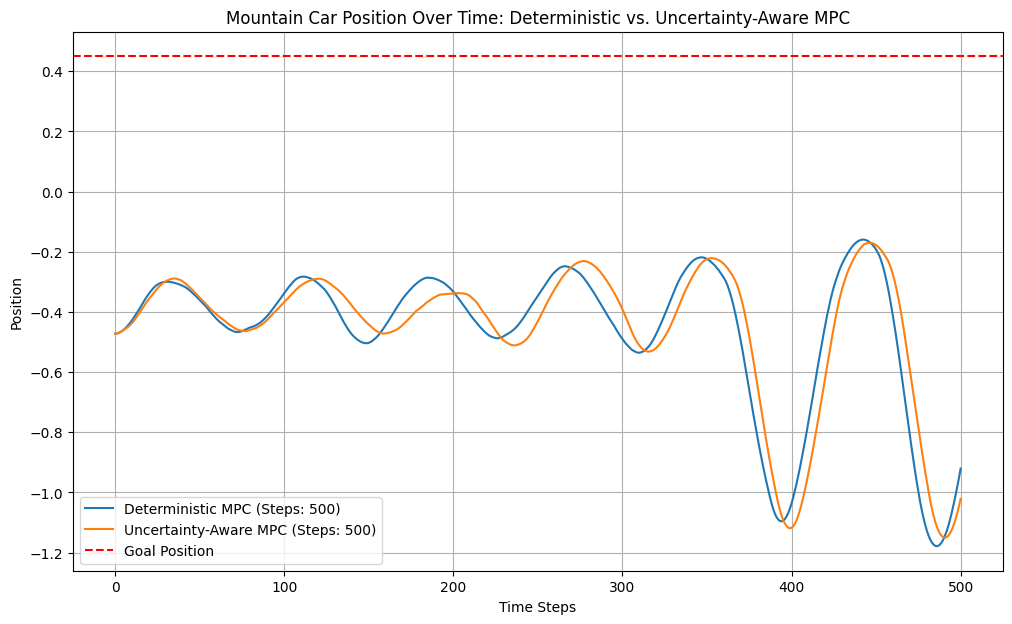

In [26]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ============================================================
# ---- Cost function (with uncertainty awareness) ------------
# ============================================================
def cost_fn_uncertainty(state, action, variance_pos, variance_vel, uncertainty_weight=1000.0):
    # state: (K, n_state) -> (K, 2) for position, velocity
    # action: (K, n_action) -> (K, 1) or (K,) for single action
    # variance_pos, variance_vel: (K,) or (K,1) -> predictive variance for position and velocity

    position = state[:, 0]
    velocity = state[:, 1]

    # Ensure action is 1D for broadcasting if it's (K,1)
    if action.ndim > 1 and action.shape[1] == 1:
        action = action.squeeze(1)

    # Basic costs (same as Exercise 1)
    goal_cost = np.where(position < 0.45, 1000.0 * (0.45 - position), 0.0)
    action_cost = 0.1 * (action**2)
    velocity_cost = np.where((position < 0.45) & (velocity < 0), 50.0 * np.abs(velocity), 0.0)

    # Uncertainty cost: Penalize trajectories with high predictive variance
    # Sum the variances for position and velocity for a combined uncertainty measure
    total_variance = variance_pos.flatten() + variance_vel.flatten()
    uncertainty_penalty = uncertainty_weight * total_variance

    return goal_cost + action_cost + velocity_cost + uncertainty_penalty


# ============================================================
# ---- Dynamics Model using GP (now returning variance) ------
# ============================================================
def gp_dynamics_with_variance(state_batch, action_batch, gps):
    # state_batch: (K, n_state)
    # action_batch: (K, n_action)

    # Ensure action_batch is 2D, even if n_action is 1
    if action_batch.ndim == 1:
        action_batch = action_batch.reshape(-1, 1)

    input_data = np.concatenate([state_batch, action_batch], axis=1)

    # Predict delta_state for position and velocity using respective GPs
    # gps[0] is for Δposition, gps[1] is for Δvelocity
    delta_pos_mean, delta_pos_var = gps[0].predict(input_data)
    delta_vel_mean, delta_vel_var = gps[1].predict(input_data)

    # Ensure predictions are 1D arrays of shape (K,)
    delta_pos = delta_pos_mean.flatten()
    delta_vel = delta_vel_mean.flatten()

    # Update state_batch
    next_position = state_batch[:, 0] + delta_pos
    next_velocity = state_batch[:, 1] + delta_vel

    return np.stack([next_position, next_velocity], axis=1), delta_pos_var, delta_vel_var


# ============================================================
# ---- MPC Action Selection (Uncertainty-Aware MPPI) --------
# ============================================================
def mpc_action_uncertainty(current_state, gps, H=15, K=500, action_bounds=[-1.0, 1.0], uncertainty_weight=1000.0):
    # H: Prediction horizon
    # K: Number of random action sequences to sample
    # action_bounds: [min_action, max_action]
    # uncertainty_weight: how much to penalize high variance

    simulated_states = np.tile(current_state, (K, 1)).astype(np.float32)
    total_costs = np.zeros(K, dtype=np.float32)

    action_sequences = np.random.uniform(
        action_bounds[0], action_bounds[1], size=(K, H, n_action)
    ).astype(np.float32)

    current_sim_states = simulated_states.copy()

    for t in range(H):
        actions_t = action_sequences[:, t, :]

        # Predict next states and their variances
        next_sim_states, delta_pos_var, delta_vel_var = gp_dynamics_with_variance(current_sim_states, actions_t, gps)

        # Calculate costs using the uncertainty-aware cost function
        step_costs = cost_fn_uncertainty(next_sim_states, actions_t, delta_pos_var, delta_vel_var, uncertainty_weight)
        total_costs += step_costs

        current_sim_states = next_sim_states

    best_trajectory_idx = np.argmin(total_costs)
    best_action = action_sequences[best_trajectory_idx, 0, :]

    return best_action


# ============================================================
# ---- Simulation Loop for both controllers ------------------
# ============================================================

# --- Deterministic MPC (from Exercise 1) ---
print(f"\n--- Running Deterministic MPC (Mean Only) ---")
env_det = gym.make("MountainCarContinuous-v0", max_episode_steps=500)
obs_det, _ = env_det.reset(seed=0)
current_state_det = obs_det
position_history_det = [current_state_det[0]]
velocity_history_det = [current_state_det[1]]
steps_det = 0

for step in range(max_steps):
    action = mpc_action(current_state_det, gps, H=H, K=K)
    next_state, reward, terminated, truncated, _ = env_det.step(action)
    current_state_det = next_state
    position_history_det.append(current_state_det[0])
    velocity_history_det.append(current_state_det[1])
    steps_det += 1
    if current_state_det[0] >= 0.45:
        print(f"Deterministic MPC: Goal reached at step {steps_det}!")
        break
    if terminated or truncated:
        print(f"Deterministic MPC: Episode ended at step {steps_det}. Goal reached: {current_state_det[0] >= 0.45}")
        break


# --- Uncertainty-Aware MPC ---
print(f"\n--- Running Uncertainty-Aware MPC (Mean + Variance) ---")
env_unc = gym.make("MountainCarContinuous-v0", max_episode_steps=500)
obs_unc, _ = env_unc.reset(seed=0)
current_state_unc = obs_unc
position_history_unc = [current_state_unc[0]]
velocity_history_unc = [current_state_unc[1]]
steps_unc = 0

for step in range(max_steps):
    action = mpc_action_uncertainty(current_state_unc, gps, H=H, K=K, uncertainty_weight=5000.0)
    next_state, reward, terminated, truncated, _ = env_unc.step(action)
    current_state_unc = next_state
    position_history_unc.append(current_state_unc[0])
    velocity_history_unc.append(current_state_unc[1])
    steps_unc += 1
    if current_state_unc[0] >= 0.45:
        print(f"Uncertainty-Aware MPC: Goal reached at step {steps_unc}!")
        break
    if terminated or truncated:
        print(f"Uncertainty-Aware MPC: Episode ended at step {steps_unc}. Goal reached: {current_state_unc[0] >= 0.45}")
        break

print("Simulation finished for both controllers.")

# ============================================================
# ---- Plotting Results --------------------------------------
# ============================================================
plt.figure(figsize=(12, 7))
plt.plot(position_history_det, label=f'Deterministic MPC (Steps: {steps_det})')
plt.plot(position_history_unc, label=f'Uncertainty-Aware MPC (Steps: {steps_unc})')
plt.axhline(y=0.45, color='r', linestyle='--', label='Goal Position')
plt.xlabel('Time Steps')
plt.ylabel('Position')
plt.title('Mountain Car Position Over Time: Deterministic vs. Uncertainty-Aware MPC')
plt.grid(True)
plt.legend()
plt.show()

# Plotting cumulative reward/steps to goal (if applicable)
# For Mountain Car, steps to goal is a good proxy for efficiency.
# We already printed steps_det and steps_unc above.

The uncertainty aware, encourage the exploration where the model is more confident. Leading to more conservative and reliable control.